In [2]:
pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.8 MB/s eta 0:00:00


In [3]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.9/379.9 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.9 MB/s eta 0:00:00


# Problema

 Fomos contratados por um dos maiores bancos do país, o Banco Seguro, como cientista de dados para ajudar a combater o aumento alarmante de fraudes em transações de cartão de crédito. Em uma reunião inicial com a equipe de segurança e prevenção de fraudes do banco, ficou claro que a situação atual está se tornando insustentável, com perdas financeiras significativas e uma crescente desconfiança por parte dos clientes.

# Objetivo

O objetivo é **analisar os dados e identificar padrões nas transações suspeitas** e  **desenvolver um sistema de detecção de fraudes** altamente eficaz que possa identificar transações suspeitas em tempo real. Isso requer a análise de grandes volumes de dados de transações de cartão de crédito em busca de padrões incomuns ou atividades fraudulentas.



# Dicionário dos dados

- **index:** Identificador único para cada linha.
- **trans_date_trans_time:** Data e hora da transação.
- **cc_num:** Número do cartão de crédito do cliente.
- **merchant:** Nome do comerciante.
- **category:** Categoria do comerciante.
- **amt:** Valor da transação.
- **first:** Primeiro nome do titular do cartão de crédito.
- **last:** Sobrenome do titular do cartão de crédito.
- **gender:** Gênero do titular do cartão de crédito.
- **street:** Endereço residencial do titular do cartão de crédito.
- **city:** Cidade do titular do cartão de crédito.
- **state:** Estado do titular do cartão de crédito.
- **zip:** CEP do titular do cartão de crédito.
- **lat:** Localização de latitude do titular do cartão de crédito.
- **long:** Localização de longitude do titular do cartão de crédito.
- **city_pop:** População da cidade do titular do cartão de crédito.
- **job:** Profissão do titular do cartão de crédito.
- **dob:** Data de nascimento do titular do cartão de crédito.
- **trans_num:** Número da transação.
- **unix_time:** Horário UNIX da transação.
- **merch_lat:** Localização de latitude do comerciante.
- **merch_long:** Localização de longitude do comerciante.
- **is_fraud:** Indicador de fraude <--- Classe Alvo.


# Importando as bibliotecas necessárias

In [4]:
import pandas as pd # Biblioteca utilizado para manipulação e análise de dados
import seaborn as sns # Biblioteca utilizada para visualização de dados
import matplotlib.pyplot as plt # Biblioteca utilizada para visualização de dados
import plotly.express as px # Biblioteca utilizada para visualização de dados
from scipy.stats import ttest_ind # Biblioteca utilizada para testes de hipótese
import holidays # Biblioteca suporte para auxiliar na busca por padrões
from datetime import datetime # Biblioteca para trabalhar com o tempo.

# Bibliotecas para auxiliar no processo de criação do algoritmo de machine learning
from sklearn.preprocessing import StandardScaler
from category_encoders import CatBoostEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
import optuna

# Biblioteca para criar novos dados sinteticos e assim balancear nosso modelo
from imblearn.over_sampling import SMOTE

# Modelos utilizados
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

# Modelo de redes neurais
import tensorflow as tf

In [5]:
treino = pd.read_csv('/content/treino.csv', sep = '|') # Lendo os dados de treino

In [6]:
treino.info() # Verificando algumas informações como quantidade de variáveis, nome das variáveis, valores não nulos e os tipos das variáveis.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144352 entries, 0 to 144351
Data columns (total 26 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ssn         144352 non-null  object 
 1   cc_num      144352 non-null  int64  
 2   first       144352 non-null  object 
 3   last        144352 non-null  object 
 4   gender      144352 non-null  object 
 5   street      144352 non-null  object 
 6   city        144352 non-null  object 
 7   state       144352 non-null  object 
 8   zip         1468 non-null    float64
 9   lat         144352 non-null  float64
 10  long        144352 non-null  float64
 11  city_pop    144352 non-null  int64  
 12  job         144352 non-null  object 
 13  dob         144352 non-null  object 
 14  acct_num    144352 non-null  int64  
 15  profile     144352 non-null  object 
 16  trans_num   144194 non-null  object 
 17  trans_date  144194 non-null  object 
 18  trans_time  144194 non-null  object 
 19  un

In [7]:
treino.duplicated().any() # Verificando se há algum valor duplicado

False

In [8]:
# Criando uma nova coluna, uninndo trans_date e trans_time
treino['trans_date_time'] = treino['trans_date'] + ' ' + treino['trans_time']

# Convertendo a nova coluna 'trans_date_time' para o tipo datetime, para que possamos trabalhar utilizando as funções próprias.
treino['trans_date_time'] = pd.to_datetime(treino['trans_date_time'])

# Análise Exploratória dos Dados

In [9]:
treino.describe() # Estatistica descritiva dos dados.

,cc_num,zip,lat,long,city_pop,acct_num,unix_time,amt,is_fraud,merch_lat,merch_long
count,1.443520e+05,1468.0,144352.000000,144352.000000,1.443520e+05,1.443520e+05,1.441940e+05,144194.000000,144194.000000,1468.000000,1468.000000
mean,3.197982e+17,37381.0,38.162887,-93.261452,3.086245e+05,5.223071e+11,1.694039e+09,71.342269,0.010597,35.690681,-84.814748
std,1.143455e+18,0.0,5.578041,16.744428,5.402505e+05,2.890281e+11,8.781565e+06,171.865793,0.102394,0.585676,0.580428
min,6.045493e+10,37381.0,25.670000,-149.780000,4.110000e+02,6.592063e+09,1.678244e+09,1.000000,0.000000,34.690000,-85.820000
25%,2.131795e+14,37381.0,34.050000,-105.090000,1.785200e+04,2.634739e+11,1.686640e+09,8.840000,0.000000,35.180000,-85.320000
50%,3.533484e+15,37381.0,39.170000,-87.990000,6.386800e+04,5.501571e+11,1.693771e+09,42.760000,0.000000,35.690000,-84.820000
75%,4.506150e+15,37381.0,41.720000,-80.300000,3.051680e+05,7.751697e+11,1.702053e+09,79.950000,0.000000,36.200000,-84.310000
max,4.997335e+18,37381.0,61.110000,-70.230000,2.906700e+06,9.993899e+11,1.709953e+09,16879.600000,1.000000,36.690000,-83.820000


Aqui vemos uma ferramenta poderosa, que são as estatísticas descritivas de nossas variáveis.

As estatisticas descritivas nos ajudam a compreender como que os dados estão distribuidos. Por exemplo: se existem valores negativos na variável "amt" que é o valor da transação. Nos permite também observar a discrepância nos dados. Ainda utilizando a variável "amt" como exemplo, vemos que até 75% dos valores é igual a 79.95 reais, mas que o valor máximo é 16879 reais. A média é 71 reais e o desvio padrão 172 reais. Esta análise prévia das estatisticas pode nos dar algumas pistas sobre padrões nas fraudes (por exemplo, fraudes tendem a ter uma média transacionada maior). É o que descobriremos ao longo do nosso estudo.

In [10]:
treino.corr() # Exibindo a correlação linear das variáveis numéricas dos nossos dados.

<ipython-input-10-b8429d737e73>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  treino.corr() # Exibindo a correlação linear das variáveis numéricas dos nossos dados.


,cc_num,zip,lat,long,city_pop,acct_num,unix_time,amt,is_fraud,merch_lat,merch_long
cc_num,1.000000,NaN,0.001285,0.053492,-0.091743,0.055559,-0.000189,0.006309,0.002694,-0.051308,0.027568
zip,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lat,0.001285,NaN,1.000000,-0.169448,-0.159943,-0.048507,0.000831,-0.000287,-0.002902,-0.019410,-0.009255
long,0.053492,NaN,-0.169448,1.000000,0.060948,0.097406,-0.000786,0.006657,-0.002870,0.023596,-0.027689
city_pop,-0.091743,NaN,-0.159943,0.060948,1.000000,0.056965,0.004224,0.006386,-0.001439,0.048545,-0.026860
acct_num,0.055559,NaN,-0.048507,0.097406,0.056965,1.000000,0.002564,0.003494,-0.002505,0.044423,-0.035449
unix_time,-0.000189,NaN,0.000831,-0.000786,0.004224,0.002564,1.000000,-0.028169,-0.001975,-0.017289,0.000608
amt,0.006309,NaN,-0.000287,0.006657,0.006386,0.003494,-0.028169,1.000000,0.283082,0.015896,-0.050527
is_fraud,0.002694,NaN,-0.002902,-0.002870,-0.001439,-0.002505,-0.001975,0.283082,1.000000,0.020397,-0.000613
merch_lat,-0.051308,NaN,-0.019410,0.023596,0.048545,0.044423,-0.017289,0.015896,0.020397,1.000000,-0.014045


In [11]:
treino['is_fraud'].value_counts() # Verificando o balanceamento de dados da nossa variável alvo.

0.0    142666
1.0      1528
Name: is_fraud, dtype: int64

<Axes: xlabel='is_fraud', ylabel='count'>

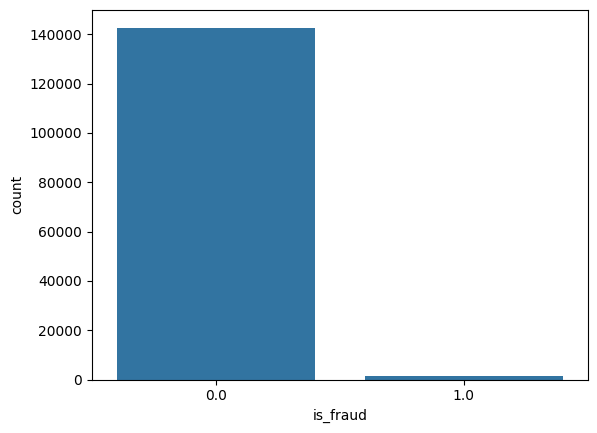

In [12]:
sns.countplot(x = 'is_fraud', data = treino) # Exibindo este desbalanceamento

A variável alvo possui um desbalanceamento muito grande, o que é um problema para os algoritmos de machine learning. Com este desbalanceamento, o modelo pode ter problemas em generalizar para a classe minoritária (fraude), o que é ruim para nós. Portanto, deveremos buscar soluções para este desbalanceamento.

Uma boa solução será utilizar a técnica SMOTE (Synthetic Minority Over-sampling Technique), que criará novas instâncias utilizando o algoritmo de K-vizinhos mais próximos para criar dados sintéticos e assim o nosso modelo generalizar bem tanto para os dados de não fraude como para os dados de fraude.

In [13]:
# Filtrando as linhas onde is_fraud é igual a 1 e verificando os valores não nulos em merch_lat e merch_long
fraudes_merch = treino.loc[treino['is_fraud'] == 1, ['merch_lat', 'merch_long']].dropna()

fraudes_merch.shape

(34, 2)

Dos dados que temos sobre a latitude e longitude das fraudes, temos apenas 34 valores de todos os 1400. Talvez seja uma boa dropar estas duas colunas ou então usar alguma biblioteca para descobrir a latitude e longitude do comerciante. Porém, utilizar de bibliotecas para descobrir a latitude e longitude do comerciante pode ser um problema pelo fato de não sabermos a localização exata.

Portanto, como regra geral, droparemos esta e outras colunas que possuem mais de 20% dos valores nulos.

In [14]:
# import holidays
feriados_usa = holidays.UnitedStates() # Pegando os dias que são feriados nos EUA

# Criando uma função para verificar se aquela data é um feriado.
def e_feriado(data):
    return 1 if data in feriados_usa else 0

# Aplicando a função para verificar se cada data na coluna 'trans_date_time' é um feriado
treino['feriado'] = treino['trans_date_time'].apply(e_feriado)

# Exibindo o resultado com a nosta nova coluna criada "feriado"
treino.head()

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,...,trans_time,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long,trans_date_time,feriado
0,176-11-8190,6591803397401489,Justin,Johnson,M,39261 Martin Garden Suite 856,Murrieta,CA,NaN,33.57,...,15:23:53,1.690137e+09,misc_pos,2.27,0.0,fraud_Thiel PLC,NaN,NaN,2023-07-23 15:23:53,0
1,481-92-6127,4772233060463333,Andrea,Ho,F,757 Ronald Trail Apt. 965,Ontario,CA,NaN,34.08,...,22:13:50,1.702516e+09,home,10.52,0.0,"fraud_Koss, Hansen and Lueilwitz",NaN,NaN,2023-12-13 22:13:50,0
2,849-66-8722,30470551694093,John,Coffey,M,097 Alexandria Stravenue,Lancaster,CA,NaN,34.69,...,23:46:47,1.690167e+09,misc_pos,149.01,0.0,fraud_Haley Group,NaN,NaN,2023-07-23 23:46:47,0
3,392-97-2182,4189092753269739,Angelica,Garcia,F,656 Moody Gateway,Carson City,NV,NaN,39.17,...,16:45:57,1.706558e+09,personal_care,32.01,0.0,"fraud_Lubowitz, Terry and Stracke",NaN,NaN,2024-01-29 16:45:57,0
4,742-37-0405,180088770435813,Travis,Jackson,M,133 Houston Ford,Rochester,NY,NaN,43.17,...,04:16:14,1.687073e+09,misc_pos,137.31,0.0,fraud_McGlynn-Jaskolski,NaN,NaN,2023-06-18 04:16:14,0


In [15]:
# Filtrando o dataframe para apenas dados de fraude
fraudes = treino[treino['is_fraud'] == 1]

# Verificando os horários que mais ocorrem as fraudes.
horario_fraudes = fraudes['trans_date_time'].dt.hour

# Contando os valores de fraudes que ocorrem por hora.
contagem_fraudes_por_hora = horario_fraudes.value_counts()

# Exibindo o horário em que as fraudes mais ocorrem.
print('Horário em que as fraudes mais ocorreram:')
print(contagem_fraudes_por_hora)

Horário em que as fraudes mais ocorreram:
22    377
23    369
3     155
0     137
1     135
2     127
12     20
14     19
15     18
16     17
10     16
20     16
13     16
21     12
19     12
6      11
8      11
9      10
18     10
17     10
7       9
5       9
11      7
4       5
Name: trans_date_time, dtype: int64


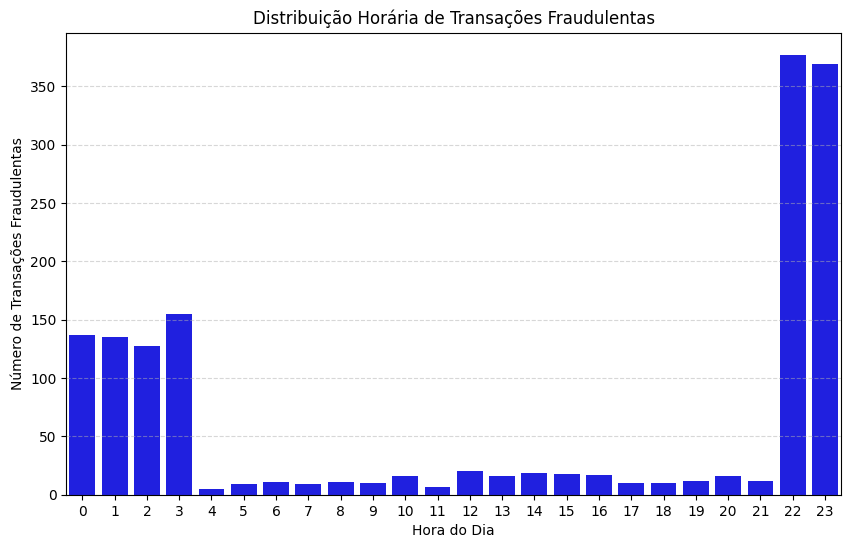

In [16]:
plt.figure(figsize=(10, 6))
sns.countplot(data=fraudes, x=fraudes['trans_date_time'].dt.hour, color='blue')
plt.xlabel('Hora do Dia')
plt.ylabel('Número de Transações Fraudulentas')
plt.title('Distribuição Horária de Transações Fraudulentas')
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [17]:
dia_fraudes = fraudes['trans_date_time'].dt.day_name()

contagem_fraudes_por_dia = dia_fraudes.value_counts()

print("Dia em que as fraudes mais ocorreram:")
print(contagem_fraudes_por_dia)

Dia em que as fraudes mais ocorreram:
Sunday       270
Friday       257
Tuesday      221
Saturday     215
Monday       189
Wednesday    189
Thursday     187
Name: trans_date_time, dtype: int64


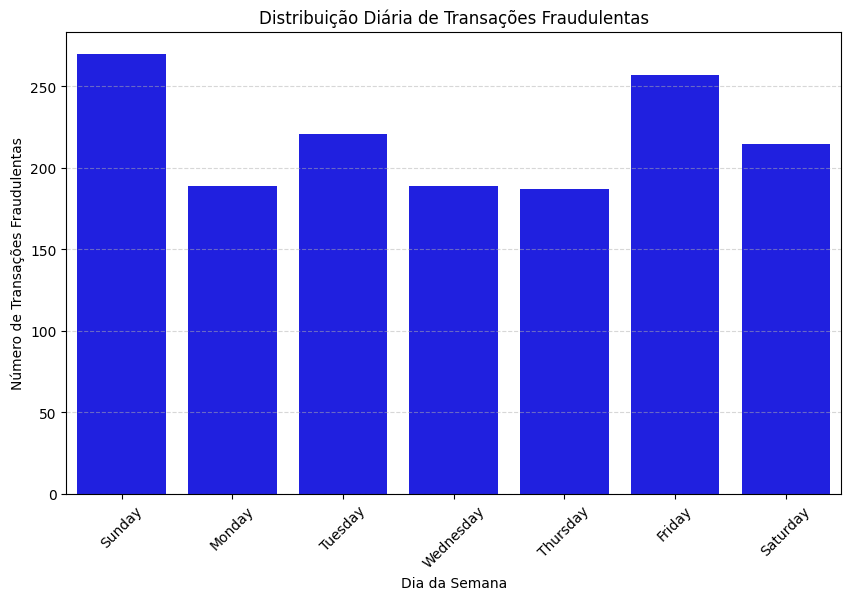

In [18]:
# Organizando a ordem que os dias da semana irão aparecer
ordem_dias_semana = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Plotando o gráfico
plt.figure(figsize=(10, 6))
sns.countplot(data=fraudes, x=fraudes['trans_date_time'].dt.day_name(), order=ordem_dias_semana, color='blue')
plt.xlabel('Dia da Semana')
plt.ylabel('Número de Transações Fraudulentas')
plt.title('Distribuição Diária de Transações Fraudulentas')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [19]:
# Separando os meses que mais ocorreram fraudes
mes_fraudes = fraudes['trans_date_time'].dt.month_name()

# Contando os valores que as fraudes aparecem
contagem_fraudes_por_mes = mes_fraudes.value_counts()

# Exibindo o mês que as fraudes mais ocorrem
print('Mês em que as fraudes mais ocorreram:')
print(contagem_fraudes_por_mes)

Mês em que as fraudes mais ocorreram:
July         226
December     159
April        153
August       145
October      145
May          123
September    119
January      111
November     105
February      83
March         81
June          78
Name: trans_date_time, dtype: int64


<ipython-input-20-1d5f6af5f059>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraudes['ano_mes_str'] = fraudes['trans_date_time'].dt.to_period('M').astype(str)
<ipython-input-20-1d5f6af5f059>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraudes['ano_mes_period'] = pd.to_datetime(fraudes['ano_mes_str']).dt.to_period('M')


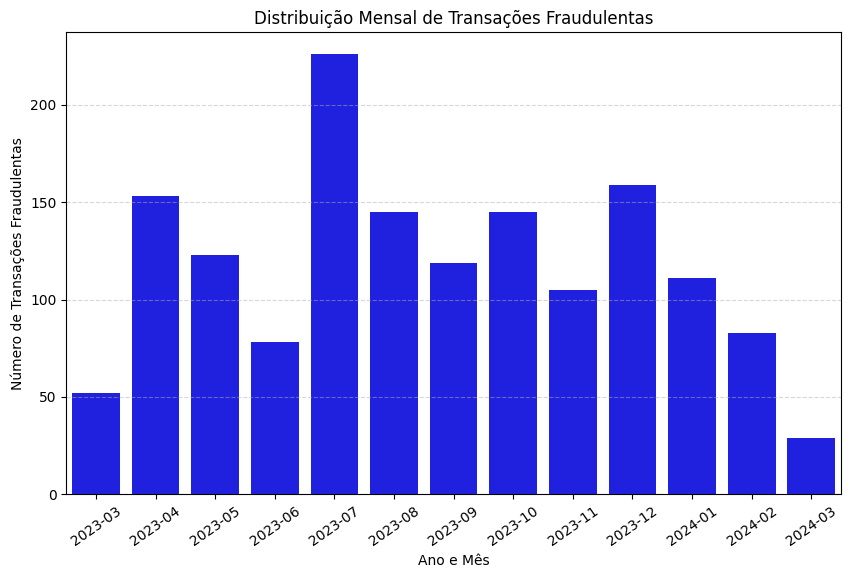

In [20]:
# Convertendo os valores de Period para strings
fraudes['ano_mes_str'] = fraudes['trans_date_time'].dt.to_period('M').astype(str)

# Convertendo os valores de string de volta para objetos Period
fraudes['ano_mes_period'] = pd.to_datetime(fraudes['ano_mes_str']).dt.to_period('M')

# Ordenando o dataframe com base no período
fraudes_sort = fraudes.sort_values('ano_mes_period')

# Plotando o histograma com os valores convertidos para strings
plt.figure(figsize=(10, 6))
sns.countplot(data=fraudes_sort, x = 'ano_mes_period', color='blue')
plt.xlabel('Ano e Mês')
plt.ylabel('Número de Transações Fraudulentas')
plt.title('Distribuição Mensal de Transações Fraudulentas')
plt.xticks(rotation=35)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [21]:
# Criando uma nova coluna "data"
fraudes['data'] = fraudes['trans_date_time'].dt.date

# Contando as datas que são fraudes
datas_fraudulentas = fraudes['data'].value_counts()

# Exibindo as 20 datas que mais ocorreram fraudes.
print('Datas com fraudes, em ordem decrescente:')
print(datas_fraudulentas.head(20))

Datas com fraudes, em ordem decrescente:
2023-03-12    25
2024-03-01    24
2023-12-15    22
2023-12-30    19
2023-07-30    18
2023-11-30    17
2023-07-27    17
2023-10-04    17
2023-08-20    17
2023-08-13    17
2023-07-18    16
2024-01-14    16
2023-07-28    15
2023-04-02    15
2023-08-05    15
2023-12-29    14
2023-06-02    13
2023-07-10    13
2023-07-16    13
2023-11-03    13
Name: data, dtype: int64


<ipython-input-21-c0f0b6d0f692>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraudes['data'] = fraudes['trans_date_time'].dt.date


In [22]:
# Verificando se cada data com fraudes é um feriado
feriados_fraude = [data for data in datas_fraudulentas.index if data in feriados_usa]

# Exibindo os feriados que ocorreram fraudes.
print('Dias de fraude que são feriados:')
print(feriados_fraude)

Dias de fraude que são feriados:
[datetime.date(2023, 7, 4), datetime.date(2023, 10, 9), datetime.date(2023, 11, 11), datetime.date(2023, 11, 23), datetime.date(2024, 1, 15), datetime.date(2023, 9, 4), datetime.date(2024, 2, 19), datetime.date(2023, 12, 25)]


In [23]:
# Filtrando as transações que são fraudes para incluir apenas aquelas que ocorreram em feriados
fraudes_nos_feriados = fraudes[fraudes['trans_date_time'].dt.date.isin(feriados_fraude)]

# Contando o número de fraudes nos feriados
total_fraudes_nos_feriados = fraudes_nos_feriados.shape[0]

# Exibindo o total de fraudes nos feriados
print('Total de fraudes ocorridas nos feriados:', total_fraudes_nos_feriados)

Total de fraudes ocorridas nos feriados: 28


Vemos então o mês, o dia da semana e as horas em que as fraudes mais ocorreram.
Podemos notar que as fraudes ocorrem majoritariamente no período da noite. Durante o período de 22:00 horas até 03:00 horas é onde está o pico de fraudes.

Os dias que mais ocorrem fraudes, na ordem, são: Domingo (270 fraudes), Sexta (257 fraudes), Terça (221 fraudes), Sábado (215 fraudes), Segunda (189 fraudes), Quarta-feira (189 fraudes) e Quinta-feira (187 fraudes)

O mês de Julho é o mês em que as fraúdes também mais ocorrem, de acordo com os nossos dados. No mês de Julho foram registradas 226 fraudes. Em segundo lugar, aparece Dezembro com 159 fraudes e em terceiro lugar aparece abril com 153 fraudes. O mês que menos ocorreu fraudes foi Junho.

**Sugestão ao banco:** Uma possível sugestão seria aumentar a segurança na madrugada das transações bancárias, principalmente aos domingos. E durante o mês do Julho fortificar ainda mais a segurança, pois é o mês em que mais ocorrem fraudes. Uma explicação para que o mês de julho mais ocorra fraudes talvez seja pelo "Summer Vacation"

In [24]:
# Separando as fraudes por cidades
fraude_por_cidade = fraudes['city']

#Exibindo as 10 primeiras cidades com mais fraudes
print('Fraudes por cidades:')
print(fraude_por_cidade.value_counts().head(10))

Fraudes por cidades:
Miami            31
Seattle          23
Riverside        21
Saint Louis      20
New York City    19
Peoria           18
Chandler         18
Denver           17
Montgomery       16
Bronx            15
Name: city, dtype: int64


As 5 cidades em que as fraudes mais ocorreram foram, na ordem: Miami        com    31 fraudes,
Seattle       com   23 fraudes,
Riverside      com  21 fraudes,
Saint Louis     com 20 fraudes e
New York City   com 19 fraudes.

In [25]:
# Agrupando a rua pelas fraudes e fazendo a soma deste valor
fraudes_por_rua = treino.groupby('street')['is_fraud'].sum()

# Ordenando pela ordem decrescente
fraudes_por_rua = fraudes_por_rua.sort_values(ascending=False)

# Exibindo as ruas que mais ocorreram fraudes
print('Ruas com o maior número de fraudes:')
print(fraudes_por_rua.head(20))

Ruas com o maior número de fraudes:
street
739 Amy Islands Suite 498          13.0
82997 Kristen Valley Suite 311     13.0
793 Evans Locks Apt. 898           13.0
26916 Carlson Mountain             13.0
083 John Lodge Suite 837           12.0
3421 Brennan Walks Suite 337       12.0
7898 Hamilton Spur Apt. 575        12.0
465 Lam Mission                    12.0
20347 Shannon Isle Suite 558       12.0
9359 Mason Circle                  12.0
904 Jay Rest Suite 723             12.0
2102 Larson Views                  11.0
108 Hoffman Ranch Suite 417        11.0
17797 Melissa Mission Suite 170    11.0
490 Thomas Run                     11.0
406 Smith Way Apt. 974             11.0
4064 Laura Plaza Suite 368         11.0
67165 Zimmerman Mews Apt. 849      11.0
1452 Christopher Squares           11.0
688 Stephens Turnpike Suite 891    11.0
Name: is_fraud, dtype: float64


In [26]:
# Contando fraudes que ocorreram por cada comerciante
fraudes_por_comerciante = fraudes['merchant'].value_counts()

# Ordenando pela ordem decrescente
fraudes_por_comerciante = fraudes_por_comerciante.sort_values(ascending=False)

# Exibindo os 10 principais comerciantes com o maior número de fraudes
print('Principais comerciantes com o maior número de fraudes:')
print(fraudes_por_comerciante.head(10))

Principais comerciantes com o maior número de fraudes:
fraud_Murray-Smitham                  13
fraud_Goldner, Kovacek and Abbott     12
fraud_Mohr-Bayer                      12
fraud_Fisher Inc                      12
fraud_Reichert, Shanahan and Hayes    11
fraud_Bailey-Morar                    11
fraud_Ankunding LLC                   11
fraud_Casper, Hand and Zulauf         11
fraud_Vandervort-Funk                 11
fraud_Bashirian Group                 11
Name: merchant, dtype: int64


<Axes: ylabel='amt'>

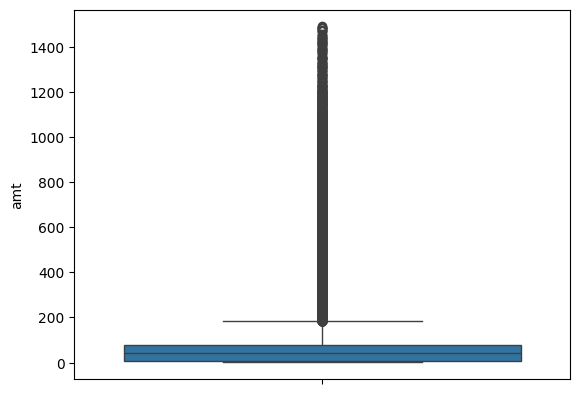

In [27]:
sns.boxplot(y = 'amt', data = treino.query('amt <= 1500'))

<Axes: xlabel='amt', ylabel='Count'>

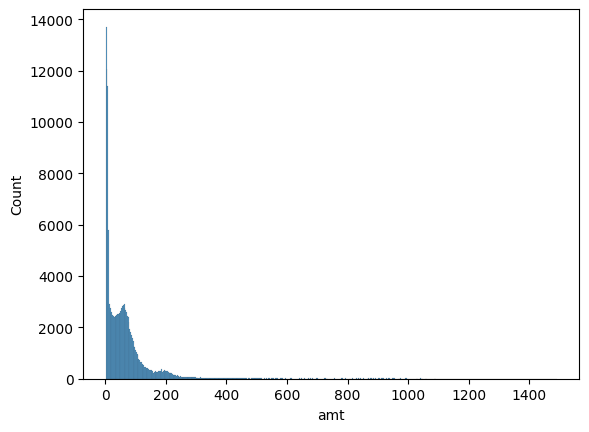

In [28]:
sns.histplot(x = 'amt', data = treino.query('amt <= 1500'))

<Axes: xlabel='amt', ylabel='Count'>

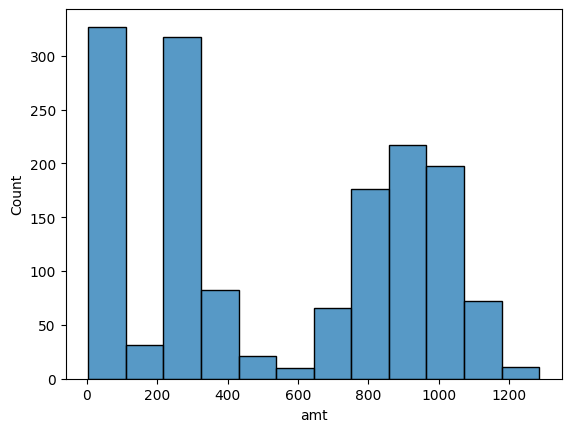

In [29]:
sns.histplot(x = 'amt', data = fraudes)

In [30]:
# from scipy.stats import ttest_ind

# Filtrando novamente os dados
fraudes = treino[treino['is_fraud'] == 1]
nao_fraudes = treino[treino['is_fraud'] == 0]

estatisticas_fraudes = fraudes['amt']
estatisticas_nao_fraudes = nao_fraudes['amt']


# Pegando 1500 amostras para cada grupo de fraudes e não fraudes
estatisticas_fraudes_n1500 = estatisticas_fraudes.sample(n = 1500, random_state = 42)
estatisticas_nao_fraudes_n1500 = estatisticas_nao_fraudes.sample(n = 1500, random_state = 42)

# Pegando o p-valor
_ , p_valor = ttest_ind(estatisticas_fraudes_n1500, estatisticas_nao_fraudes_n1500)

print('=' * 100)
print('Estatisticas para fraudes')
print(estatisticas_fraudes.describe())
print('=' * 100)
print('Estatisticas para não fraudes')
print(estatisticas_nao_fraudes.describe())
print('=' * 100)
print('Teste t para verificar se as médias dos grupos são iguais ou diferentes')
print('P-valor:', p_valor.round(3))

Estatisticas para fraudes
count    1528.000000
mean      541.451774
std       394.373423
min         4.610000
25%       259.262500
50%       472.770000
75%       915.385000
max      1284.230000
Name: amt, dtype: float64
Estatisticas para não fraudes
count    142666.000000
mean         66.307241
std         160.614840
min           1.000000
25%           8.770000
50%          42.275000
75%          78.860000
max       16879.600000
Name: amt, dtype: float64
Teste t para verificar se as médias dos grupos são iguais ou diferentes
P-valor: 0.0


As hipóteses são:


H0: μ1 = μ2

HA: μ1 ≠ μ2

Estabelecido um nível de significância de 0.05, vemos que o p-valor é bem próximo de 0, ou seja, rejeitamos a hipótese nula de que as médias são iguais. Portanto, a média da quantidade transacionada para o grupo de não fraudes e o grupo de fraudes são diferentes.

E visualizando o gráfico e a sua média, podemos ver que fraudes geralmente ocorrem com uma quantidade transacionada maior.

In [31]:
# Agrupando a categoria pelo fato de ser fraude ou não
fraudes_por_categoria = fraudes.groupby('category')['is_fraud'].sum()

# Ordenando em valor decrescente
fraudes_por_categoria = fraudes_por_categoria.sort_values(ascending=False)

# Exibindo as categorias de comerciantes com o maior número total de fraudes
print('Categorias de comerciantes com o maior número total de fraudes:')
print(fraudes_por_categoria)

Categorias de comerciantes com o maior número total de fraudes:
category
shopping_net      352.0
grocery_pos       345.0
misc_net          200.0
shopping_pos      186.0
gas_transport     138.0
home               47.0
entertainment      43.0
kids_pets          40.0
misc_pos           39.0
personal_care      34.0
food_dining        33.0
grocery_net        24.0
health_fitness     24.0
travel             23.0
Name: is_fraud, dtype: float64


Notamos que as categorias de comerciantes que mais houveram fraudes foi shopping_net, grocery_pos, misc_net, shopping_pos e gas_transport.

In [32]:
# Agrupando os gêneros pela fraude
taxa_de_fraude_por_genero = fraudes.groupby('gender')['is_fraud'].sum()


# Exibindo a taxa de fraudes por gênero
print('Taxa de fraudes por gênero da pessoa:')
taxa_de_fraude_por_genero

Taxa de fraudes por gênero da pessoa:


gender
F    770.0
M    758.0
Name: is_fraud, dtype: float64

Entre os individuos que houveram fraudes no cartão, não há distinção entre homens e mulheres.

In [33]:
taxa_de_fraude_por_job = fraudes['job']
print('Taxa de fraudes por gênero da pessoa:')
print(taxa_de_fraude_por_job.value_counts().head(20))

Taxa de fraudes por gênero da pessoa:
Social research officer, government                  34
Clothing/textile technologist                        24
Therapist, speech and language                       21
Emergency planning/management officer                21
Recycling officer                                    20
Accounting technician                                20
Paediatric nurse                                     19
Quarry manager                                       18
Sports development officer                           18
Engineer, civil (contracting)                        18
Accountant, chartered certified                      18
Historic buildings inspector/conservation officer    18
Statistician                                         17
Retail buyer                                         17
General practice doctor                              17
Product manager                                      15
Health and safety inspector                          15
Engineer, 

Entre o trabalho do titular do cartão, "Social research officer, government" foram os que mais tiveram fraudes com 34 fraudes, seguidos pelo Clothing/textile technologist com 24 fraudes.

# Feature Engineering

O processo conhecido como "Feature Engineering" envolve a seleção, criação, transformação e o tratamento dos dados do nosso modelo.

No nosso caso, estaremos removendo as linhas com os valores ausentes da coluna is_fraud e também estaremos criando novas colunas e dropando algumas outras colunas que tem muitos valores faltantes ou que não nos ajuda a realizar a previsão do nosso modelo.

In [34]:
# Remover linhas com valores ausentes na coluna 'is_fraud'
treino.dropna(subset=['is_fraud'], inplace=True)

In [35]:
# Criando novas variáveis
def dataframe_create(dataframe):
  hoje = datetime.now()
  dataframe['trans_date_time'] = dataframe['trans_date'] + ' ' + dataframe['trans_time']
  dataframe['trans_date_time'] = pd.to_datetime(dataframe['trans_date_time'])
  dataframe['feriado'] = dataframe['trans_date_time'].apply(e_feriado)
  dataframe['dob'] = pd.to_datetime(dataframe['dob'])
  dataframe['idade'] = (hoje - dataframe['dob']).astype('<m8[Y]')
  dataframe['dia_semana'] = dataframe['trans_date_time'].dt.dayofweek
  dataframe['hora'] = dataframe['trans_date_time'].dt.hour

# Dropando algumas variáveis
def dataframe_drops(dataframe):
  dataframe.drop(columns = ['first', 'last', 'zip','trans_date', 'ssn',
                            'profile', 'trans_date_time', 'trans_time', 'trans_num', 'merch_lat', 'merch_long', 'dob'], inplace = True)



In [36]:
dataframe_create(treino)

In [37]:
dataframe_drops(treino)

In [38]:
treino.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144194 entries, 0 to 144351
Data columns (total 19 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   cc_num      144194 non-null  int64  
 1   gender      144194 non-null  object 
 2   street      144194 non-null  object 
 3   city        144194 non-null  object 
 4   state       144194 non-null  object 
 5   lat         144194 non-null  float64
 6   long        144194 non-null  float64
 7   city_pop    144194 non-null  int64  
 8   job         144194 non-null  object 
 9   acct_num    144194 non-null  int64  
 10  unix_time   144194 non-null  float64
 11  category    144194 non-null  object 
 12  amt         144194 non-null  float64
 13  is_fraud    144194 non-null  float64
 14  merchant    144194 non-null  object 
 15  feriado     144194 non-null  int64  
 16  idade       144194 non-null  float64
 17  dia_semana  144194 non-null  int64  
 18  hora        144194 non-null  int64  
dtypes:

# Machine Learning

Agora iremos por a mão na massa e começar a desenvolver modelos de machine learning para realizar a previsão.

In [39]:
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from category_encoders import CatBoostEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.model_selection import train_test_split


X = treino.drop('is_fraud', axis = 1)
y = treino['is_fraud']

cols_num = list(set(X.select_dtypes('number')))
cols_cat = list(set(X.select_dtypes('object')))

pipe_cat = Pipeline([('encoder', CatBoostEncoder())])
pipe_num = Pipeline([('std_scaler', StandardScaler())])

preprocessor = ColumnTransformer([('numeric', pipe_num, cols_num),
                                  ('categoric', pipe_cat, cols_cat)])
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('std_scaler',
                                                  StandardScaler())]),
                                 ['city_pop', 'acct_num', 'dia_semana', 'lat',
                                  'long', 'amt', 'feriado', 'idade', 'hora',
                                  'cc_num', 'unix_time']),
                                ('categoric',
                                 Pipeline(steps=[('encoder',
                                                  CatBoostEncoder())]),
                                 ['category', 'gender', 'street', 'state',
                                  'merchant', 'city', 'job'])])

A escolha do CatBoostEncoder foi porque há uma grande quantidade de variáveis com muitas categorias e o CatBoostEncoder tem essa robustez de evitar o overfitting ou problemas relacionados. O TargetEncoder era uma opção, entretanto, ele não tem essa robustez.

Outro Encoder comumente utilizado é o OneHotEncoder, mas devido a grande quantidade de variáveis e suas categorias no nosso modelo, isso levaria a um aumento da dimensionalidade do modelo.

O CatBoostEncoder permite adicionar novas categorias durante o deploy do aplicativo também, ao contrário de outros codificadores como o OneHotEncoder. Este encodificador pode lidar com novas categorias que não estavam presentes nos dados de treinamento.

In [40]:
SEED = 42

X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.3, stratify = y, random_state = SEED)

In [41]:
X_treino_preprocessado = preprocessor.fit_transform(X_treino, y_treino)

X_teste_preprocessado = preprocessor.transform(X_teste)

In [42]:
# from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = SEED)

Usando a técnica SMOTE para balancear os dados. SMOTE irá criar dados sinteticos para a nossa variável alvo ficar balanceada, utilizando como base a técnica do K-vizinhos mais próximos.

In [43]:
X_treino_preprocessado_resampled, y_treino_resampled = sm.fit_resample(X_treino_preprocessado, y_treino)

In [44]:
y_treino_resampled.shape

(199730,)

<Axes: xlabel='is_fraud', ylabel='count'>

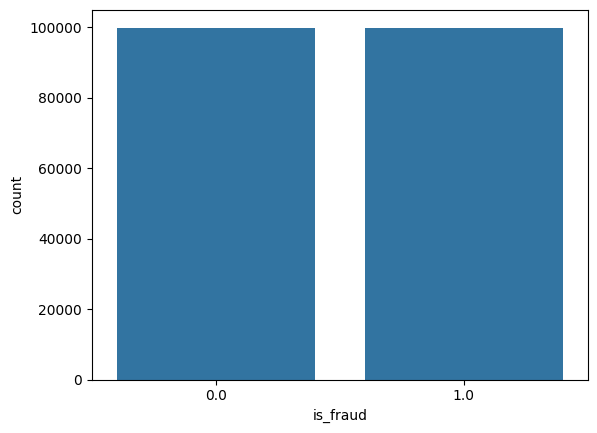

In [45]:
teste_df = pd.DataFrame(y_treino_resampled)
sns.countplot(x = 'is_fraud', data = teste_df)

Podemos notar que agora a nossa variável alvo está balanceada.

Iremos rodar agora alguns modelos de Machine Learning e verificar algumas de suas métricas.

# Regressão Logística

O primeiro modelo e um modelo comumente utilizado neste cenário é o de Regressão Logistica. Iremos rodar o modelo de regressão logística para detectar fraudes.

In [46]:
# from sklearn.linear_model import LogisticRegression

modelo_lr = LogisticRegression(max_iter = 1000, random_state=SEED)

modelo_lr.fit(X_treino_preprocessado_resampled, y_treino_resampled)

y_teste_previsto = modelo_lr.predict(X_teste_preprocessado)

In [47]:
# from sklearn.metrics import classification_report

print(classification_report(y_teste, y_teste_previsto))

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98     42801
         1.0       0.16      0.75      0.26       458

    accuracy                           0.96     43259
   macro avg       0.58      0.86      0.62     43259
weighted avg       0.99      0.96      0.97     43259



Em modelos que o objetivo é detectar fraudes ou churns, por exemplo, geralmente é mais viável focar em métricas como Recall e F1-Score. Por que?
Porque o recall irá medir a capacidade do modelo de identificar as instâncias positivas - fraudes - corretamente. Em cenários como detecção de fraúdes e churn, é muito crucial detectar o máximo possível de casos verdadeiros. Fraudes, por exemplo, tem consequências financeiras graves, portanto, detectar o número de fraude é essencial.

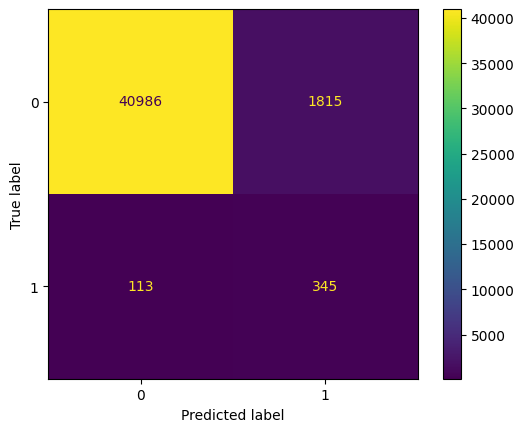

In [48]:
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import ConfusionMatrixDisplay

matriz = confusion_matrix(y_teste, y_teste_previsto)
disp = ConfusionMatrixDisplay(confusion_matrix=matriz)
disp.plot()

Matriz de confusão é uma tabela em que é mostrado o resultado do modelo de classificação para cade classe do modelo.  Usamos matriz de confusão quando queremos verificar o desempenho do modelo. A matriz de confusão possui quatro categorias:

**Verdadeiros positivos**: casos em que o modelo previu corretamente uma classe como positiva.

**Falsos positivos**: casos em que o modelo previu incorretamente uma classe como positiva quando na verdade era negativa.

**Verdadeiros negativos**: casos em que o modelo previu corretamente uma classe como negativa.

**Falsos negativos**: casos em que o modelo previu incorretamente uma classe como negativa quando na verdade era positiva.

Verdadeiros Positivos (TP) | Falsos Negativos (FN)
----------------------------|----------------------------
Falsos Positivos (FP)      | Verdadeiros Negativos (TN)


As métricas que conhecemos, como precisão, recall e f1-score como vimos no **classification_report** é calculada a partir de informações que também estão disponíveis na matriz de confusão.

Por exemplo, a métrica recall é calculada pela fórmula:
Recall = Verdadeiros Positivos / (Verdadeiros Positivos + Falsos Negativos)

roc_auc 0.8855823472271237


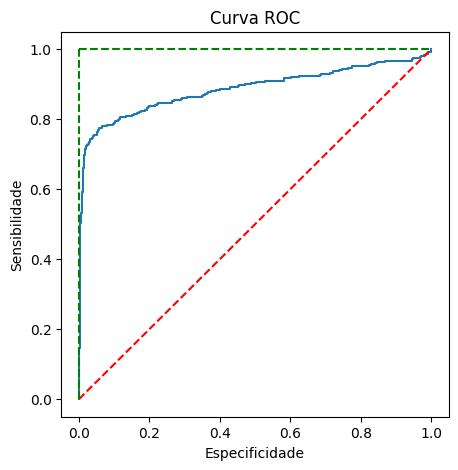

In [49]:
# from sklearn.metrics import roc_curve, roc_auc_score

prob_previsao = modelo_lr.predict_proba(X_teste_preprocessado)[:,1]

#tfp = taxa de falso positivos
#tvp = taxa de verdadeiro positivo

tfp, tvp, limite = roc_curve(y_teste, prob_previsao)
print('roc_auc', roc_auc_score(y_teste, prob_previsao))

plt.subplots(1, figsize = (5, 5))
plt.title('Curva ROC')
plt.plot(tfp, tvp)
plt.xlabel('Especificidade')
plt.ylabel('Sensibilidade')
plt.plot([0, 1], ls = '--', c = 'red') # plotando linha guia pontilhada vermelha
plt.plot([0, 0], [1, 0], ls = '--', c = 'green'), plt.plot([1, 1], ls = '--', c = 'green') # plotando linha guia verde
plt.show()

# Árvore de Decisão

O nosso segundo modelo será o modelo de Árvore de Decisão

In [50]:
# # from sklearn.tree import DecisionTreeClassifier

# modelo_dtc = DecisionTreeClassifier(random_state=SEED)


# modelo_dtc.fit(X_treino_preprocessado_resampled, y_treino_resampled)

# y_teste_previsto = modelo_dtc.predict(X_teste_preprocessado)

In [51]:
# # from sklearn.metrics import classification_report

# print(classification_report(y_teste, y_teste_previsto))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     42801
         1.0       0.52      0.72      0.61       458

    accuracy                           0.99     43259
   macro avg       0.76      0.86      0.80     43259
weighted avg       0.99      0.99      0.99     43259



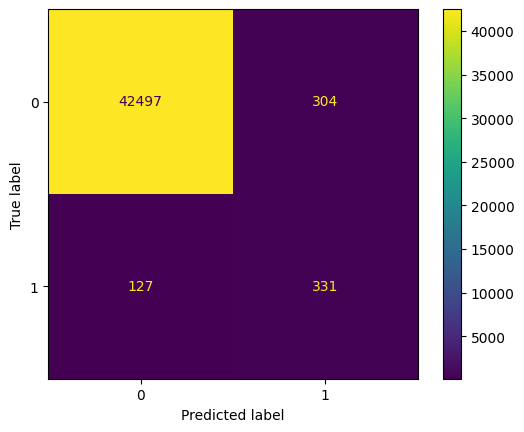

In [52]:
# #from sklearn.metrics import confusion_matrix
# #from sklearn.metrics import ConfusionMatrixDisplay

# matriz = confusion_matrix(y_teste, y_teste_previsto)
# disp = ConfusionMatrixDisplay(confusion_matrix=matriz)
# disp.plot()

roc_auc 0.8578023928959747


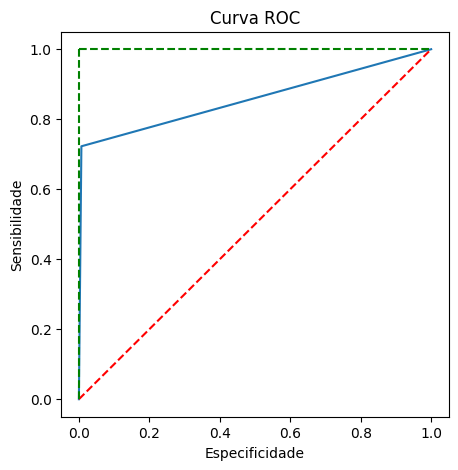

In [53]:
# # from sklearn.metrics import roc_curve, roc_auc_score

# prob_previsao = modelo_dtc.predict_proba(X_teste_preprocessado)[:,1]

# #tfp = taxa de falso positivos
# #tvp = taxa de verdadeiro positivo

# tfp, tvp, limite = roc_curve(y_teste, prob_previsao)
# print('roc_auc', roc_auc_score(y_teste, prob_previsao))

# plt.subplots(1, figsize = (5, 5))
# plt.title('Curva ROC')
# plt.plot(tfp, tvp)
# plt.xlabel('Especificidade')
# plt.ylabel('Sensibilidade')
# plt.plot([0, 1], ls = '--', c = 'red') # plotando linha guia pontilhada vermelha
# plt.plot([0, 0], [1, 0], ls = '--', c = 'green'), plt.plot([1, 1], ls = '--', c = 'green') # plotando linha guia verde
# plt.show()

# Floresta Aleatória

O nosso terceiro modelo será um modelo de Floresta Aleatória.

In [54]:
# from sklearn.ensemble import RandomForestClassifier

# modelo_rfc = RandomForestClassifier(random_state=SEED)


# modelo_rfc.fit(X_treino_preprocessado_resampled, y_treino_resampled)

# y_teste_previsto = modelo_rfc.predict(X_teste_preprocessado)

In [55]:
# from sklearn.metrics import classification_report

# print(classification_report(y_teste, y_teste_previsto))

In [56]:
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import ConfusionMatrixDisplay

# matriz = confusion_matrix(y_teste, y_teste_previsto)
# disp = ConfusionMatrixDisplay(confusion_matrix=matriz)
# disp.plot()

In [57]:
# from sklearn.metrics import roc_curve, roc_auc_score

# prob_previsao = modelo_rfc.predict_proba(X_teste_preprocessado)[:,1]

# #tfp = taxa de falso positivos
# #tvp = taxa de verdadeiro positivo

# tfp, tvp, limite = roc_curve(y_teste, prob_previsao)
# print('roc_auc', roc_auc_score(y_teste, prob_previsao))

# plt.subplots(1, figsize = (5, 5))
# plt.title('Curva ROC')
# plt.plot(tfp, tvp)
# plt.xlabel('Especificidade')
# plt.ylabel('Sensibilidade')
# plt.plot([0, 1], ls = '--', c = 'red') # plotando linha guia pontilhada vermelha
# plt.plot([0, 0], [1, 0], ls = '--', c = 'green'), plt.plot([1, 1], ls = '--', c = 'green') # plotando linha guia verde
# plt.show()

# XGBoost

O terceiro modelo será o modelo de XGBoost

In [69]:
# import optuna
# from sklearn.metrics import f1_score
# from sklearn.model_selection import train_test_split
# from xgboost import XGBClassifier

def objective(trial):
    params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'eval_metric': 'logloss'
    }

    modelo_xgb = XGBClassifier(**params)
    modelo_xgb.fit(X_treino_preprocessado_resampled, y_treino_resampled)

    threshold = trial.suggest_float('threshold', 0.1, 0.9)

    y_previsto_proba = modelo_xgb.predict_proba(X_teste_preprocessado)[:, 1]
    y_pred = (y_previsto_proba > threshold).astype(int)

    return f1_score(y_teste, y_pred)

estudo = optuna.create_study(direction='maximize')
estudo.optimize(objective, n_trials=50)

best_params = estudo.best_params

print('Melhores parâmetros encontrados:')
print(best_params)

[I 2024-03-22 02:51:57,454] A new study created in memory with name: no-name-23212ebb-5a2a-4cd1-80c8-3317a6707bf6
[I 2024-03-22 02:52:20,170] Trial 0 finished with value: 0.858173076923077 and parameters: {'n_estimators': 591, 'learning_rate': 0.05503785726418063, 'gamma': 0.394038345070187, 'subsample': 0.6053310969835595, 'colsample_bytree': 0.580074637604821, 'max_depth': 9, 'min_child_weight': 12, 'reg_lambda': 1.2811414579411975, 'reg_alpha': 0.00854191750168845, 'threshold': 0.7487183524013062}. Best is trial 0 with value: 0.858173076923077.
[I 2024-03-22 02:52:31,496] Trial 1 finished with value: 0.6895910780669146 and parameters: {'n_estimators': 409, 'learning_rate': 0.018441484474891356, 'gamma': 0.39404412264301447, 'subsample': 0.9621414206027388, 'colsample_bytree': 0.7470597756669818, 'max_depth': 6, 'min_child_weight': 13, 'reg_lambda': 7.094071762612906, 'reg_alpha': 1.8636815389103714, 'threshold': 0.5944548633822416}. Best is trial 0 with value: 0.858173076923077.
[I 

Melhores parâmetros encontrados:
{'n_estimators': 801, 'learning_rate': 0.09922541356450826, 'gamma': 0.12345580798801424, 'subsample': 0.8783926249809052, 'colsample_bytree': 0.8315633560996112, 'max_depth': 6, 'min_child_weight': 3, 'reg_lambda': 1.3193913278434486e-07, 'reg_alpha': 7.984625887733128e-06, 'threshold': 0.6705955458055817}


In [70]:
modelo_xgb = XGBClassifier(**best_params, seed=SEED)

modelo_xgb.fit(X_treino_preprocessado_resampled, y_treino_resampled)

y_teste_previsto = modelo_xgb.predict(X_teste_preprocessado)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:10:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "threshold" } are not used.

  warnings.warn(smsg, UserWarning)


In [71]:
# from sklearn.metrics import classification_report

print(classification_report(y_teste, y_teste_previsto))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     42801
         1.0       0.93      0.83      0.88       458

    accuracy                           1.00     43259
   macro avg       0.96      0.91      0.94     43259
weighted avg       1.00      1.00      1.00     43259



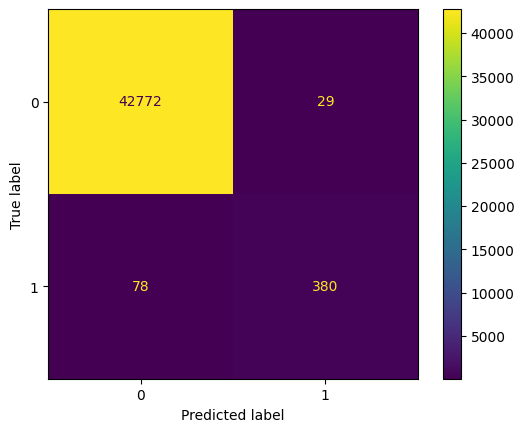

In [72]:
# # from sklearn.metrics import confusion_matrix
# # from sklearn.metrics import ConfusionMatrixDisplay

matriz = confusion_matrix(y_teste, y_teste_previsto)
disp = ConfusionMatrixDisplay(confusion_matrix=matriz)
disp.plot()

roc_auc 0.9927389159274631


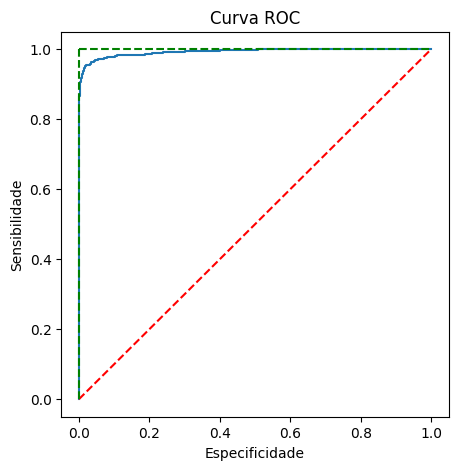

In [73]:
# from sklearn.metrics import roc_curve, roc_auc_score

prob_previsao = modelo_xgb.predict_proba(X_teste_preprocessado)[:,1]

#tfp = taxa de falso positivos
#tvp = taxa de verdadeiro positivo

tfp, tvp, limite = roc_curve(y_teste, prob_previsao)
print('roc_auc', roc_auc_score(y_teste, prob_previsao))

plt.subplots(1, figsize = (5, 5))
plt.title('Curva ROC')
plt.plot(tfp, tvp)
plt.xlabel('Especificidade')
plt.ylabel('Sensibilidade')
plt.plot([0, 1], ls = '--', c = 'red') # plotando linha guia pontilhada vermelha
plt.plot([0, 0], [1, 0], ls = '--', c = 'green'), plt.plot([1, 1], ls = '--', c = 'green') # plotando linha guia verde
plt.show()

# LightGBM

O quarto modelo será o modelo LightGBM

In [74]:
# import optuna

def objective(trial):
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "random_state": 42,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 30)
    }

    modelo_lgb = lgb.LGBMClassifier(**params)
    modelo_lgb.fit(X_treino_preprocessado_resampled, y_treino_resampled)

    y_previsto = modelo_lgb.predict(X_teste_preprocessado)

    score = f1_score(y_teste, y_previsto)

    return score


estudo = optuna.create_study(direction='maximize')
estudo.optimize(objective, n_trials=50)

best_params = estudo.best_params
print('Melhores parâmetros encontrados:')
print(best_params)

[I 2024-03-22 03:16:22,168] A new study created in memory with name: no-name-eac600d8-a74a-499e-9c38-444ad1e31545
[I 2024-03-22 03:16:53,336] Trial 0 finished with value: 0.8715596330275229 and parameters: {'learning_rate': 0.03644453323140461, 'n_estimators': 923, 'lambda_l1': 7.699944664131447e-05, 'lambda_l2': 0.02346424479712982, 'max_depth': 8, 'colsample_bytree': 0.7958103244223297, 'subsample': 0.6288846167323519, 'min_child_samples': 23}. Best is trial 0 with value: 0.8715596330275229.
[I 2024-03-22 03:17:00,519] Trial 1 finished with value: 0.7852760736196319 and parameters: {'learning_rate': 0.07230239650638774, 'n_estimators': 197, 'lambda_l1': 2.23465911164847e-06, 'lambda_l2': 0.02675854656514016, 'max_depth': 7, 'colsample_bytree': 0.8374508296248837, 'subsample': 0.7512890556969096, 'min_child_samples': 21}. Best is trial 0 with value: 0.8715596330275229.
[I 2024-03-22 03:17:21,200] Trial 2 finished with value: 0.8750000000000001 and parameters: {'learning_rate': 0.05693

Melhores parâmetros encontrados:
{'learning_rate': 0.0609487349848596, 'n_estimators': 999, 'lambda_l1': 0.03900213918429928, 'lambda_l2': 0.1372785318530496, 'max_depth': 9, 'colsample_bytree': 0.8626284401396019, 'subsample': 0.6622813580888127, 'min_child_samples': 8}


In [75]:
# import lightgbm as lgb
modelo_lgb = lgb.LGBMClassifier(**best_params, verbose=100)

modelo_lgb.fit(X_treino_preprocessado_resampled, y_treino_resampled)

y_teste_previsto = modelo_lgb.predict(X_teste_preprocessado)

[LightGBM] [Warning] lambda_l2 is set=0.1372785318530496, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1372785318530496
[LightGBM] [Warning] lambda_l1 is set=0.03900213918429928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03900213918429928
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l2 is set=0.1372785318530496, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1372785318530496
[LightGBM] [Warning] lambda_l1 is set=0.03900213918429928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03900213918429928
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 99865, number of negative: 99865
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.054395
[LightGBM] [Debug] init for col-wise cost 0.000010 sec

In [76]:
# from sklearn.metrics import classification_report

print(classification_report(y_teste, y_teste_previsto))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     42801
         1.0       0.95      0.84      0.89       458

    accuracy                           1.00     43259
   macro avg       0.97      0.92      0.94     43259
weighted avg       1.00      1.00      1.00     43259



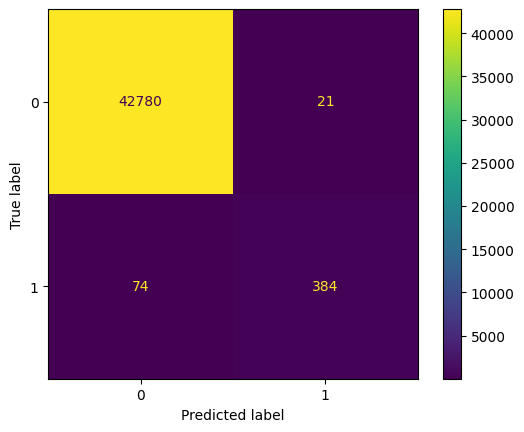

In [77]:
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import ConfusionMatrixDisplay

matriz = confusion_matrix(y_teste, y_teste_previsto)
disp = ConfusionMatrixDisplay(confusion_matrix=matriz)
disp.plot()

[LightGBM] [Warning] lambda_l2 is set=0.1372785318530496, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1372785318530496
[LightGBM] [Warning] lambda_l1 is set=0.03900213918429928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03900213918429928
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
roc_auc 0.9926251570051674


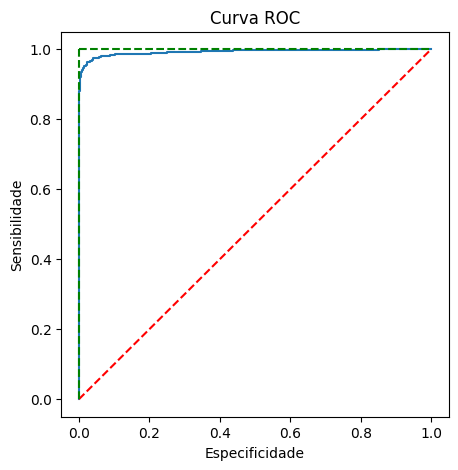

In [78]:
# from sklearn.metrics import roc_curve, roc_auc_score

prob_previsao = modelo_lgb.predict_proba(X_teste_preprocessado)[:,1]

#tfp = taxa de falso positivos
#tvp = taxa de verdadeiro positivo

tfp, tvp, limite = roc_curve(y_teste, prob_previsao)
print('roc_auc', roc_auc_score(y_teste, prob_previsao))

plt.subplots(1, figsize = (5, 5))
plt.title('Curva ROC')
plt.plot(tfp, tvp)
plt.xlabel('Especificidade')
plt.ylabel('Sensibilidade')
plt.plot([0, 1], ls = '--', c = 'red') # plotando linha guia pontilhada vermelha
plt.plot([0, 0], [1, 0], ls = '--', c = 'green'), plt.plot([1, 1], ls = '--', c = 'green') # plotando linha guia verde
plt.show()

# Validação cruzada: LightGBM vs XGBoost

In [79]:
from imblearn.pipeline import Pipeline as PipelineIMB

pipeline_xgb = PipelineIMB([('preprocessor', preprocessor),
                              ('resampler', SMOTE()),
                              ('model', modelo_xgb)])
pipeline_xgb

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['city_pop', 'acct_num',
                                                   'dia_semana', 'lat', 'long',
                                                   'amt', 'feriado', 'idade',
                                                   'hora', 'cc_num',
                                                   'unix_time']),
                                                 ('categoric',
                                                  Pipeline(steps=[('encoder',
                                                                   CatBoostEncoder())]),
                                                  ['category', 'gender',
                                                   'street', 'state',
                                                   'merchant', 'city',
                                                   'job'...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.09922541356450826, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=6,
                               max_leaves=None, min_child_weight=3, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=801, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [85]:
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import cross_val_score

scoring = make_scorer(recall_score)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_val_score(pipeline_xgb, X, y, cv=kf, scoring=scoring)

print('Recall médio nos folds:', cv_results.mean())

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:53:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "threshold" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:53:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "threshold" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:54:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "threshold" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:54:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "threshold" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:54:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "threshold" } are not used.

  warnings.warn

Recall médio nos folds: 0.8787427789279263


In [82]:
pipeline_lgbm = PipelineIMB([('preprocessor', preprocessor),
                              ('resampler', SMOTE()),
                              ('model', modelo_lgb)])
pipeline_lgbm

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['city_pop', 'acct_num',
                                                   'dia_semana', 'lat', 'long',
                                                   'amt', 'feriado', 'idade',
                                                   'hora', 'cc_num',
                                                   'unix_time']),
                                                 ('categoric',
                                                  Pipeline(steps=[('encoder',
                                                                   CatBoostEncoder())]),
                                                  ['category', 'gender',
                                                   'street', 'state',
                                                   'merchant', 'city',
                                                   'job'])])),
                ('resampler', SMOTE()),
                ('model',
                 LGBMClassifier(colsample_bytree=0.8626284401396019,
                                lambda_l1=0.03900213918429928,
                                lambda_l2=0.1372785318530496,
                                learning_rate=0.0609487349848596, max_depth=9,
                                min_child_samples=8, n_estimators=999,
                                subsample=0.6622813580888127, verbose=100))])

In [83]:
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import cross_val_score

scoring = make_scorer(recall_score)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_val_score(pipeline_lgbm, X, y, cv=kf, scoring=scoring)

print('Recall médio nos folds:', cv_results.mean())

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Traine

# Melhor modelo

O melhor modelo foi o modelo LightGBM através da otimização de hiperparâmetros com a ajuda da biblioteca Optuna.

Optuna é uma biblioteca de otimização de hiperparâmetros automatizada para machine learning. Esta biblioteca oferece uma abordagem flexível e eficiente para encontrar os melhores conjuntos de hiperparâmetros para modelos de machine learning.

O modelo ainda pode ser melhorado. Podemos testar outros, podemos testar novas variáveis, podemos remover variáveis que tem uma baixa explicação no nosso modelo através da análise de feature importances, análise SHAP e etc. Faremos isso em breve.

# Salvando o modelo

In [104]:
import joblib

pipeline_lgbm = PipelineIMB([('preprocessor', preprocessor),
                              ('resampler', SMOTE()),
                              ('model', modelo_lgb)])

joblib.dump(pipeline_lgbm, 'modelo_lgbm.pkl')

['modelo_lgbm.pkl']

# Próximo passo

O próximo passo será o deploy do modelo via streamlit.

# BÔNUS: DNN

In [106]:
import tensorflow as tf

modelo_dnn = tf.keras.Sequential([
    Dense(495, activation='relu', input_shape=(X_treino_preprocessado_resampled.shape[1],)),
    Dropout(0.17774559519707114), # Número obtido via optuna
    Dense(92, activation='relu'), # Número obtido via optuna
    Dropout(0.362769250816939), # Número obtido via optuna
    Dense(97.11452567414916, activation = 'relu'), # Número obtido via optuna
    Dropout(0.262769250816939), # Número obtido via optuna
    Dense(1, activation='sigmoid') # Número obtido via optuna
])


modelo_dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Recall()])


modelo_dnn.fit(X_treino_preprocessado_resampled, y_treino_resampled, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
2497/2497 [==============================] - 22s 7ms/step - loss: 0.1775 - recall_3: 0.8943 - val_loss: 0.1541 - val_recall_3: 0.9342
Epoch 2/10
2497/2497 [==============================] - 13s 5ms/step - loss: 0.1114 - recall_3: 0.9374 - val_loss: 0.1134 - val_recall_3: 0.9533
Epoch 3/10
2497/2497 [==============================] - 13s 5ms/step - loss: 0.0870 - recall_3: 0.9560 - val_loss: 0.0646 - val_recall_3: 0.9802
Epoch 4/10
2497/2497 [==============================] - 13s 5ms/step - loss: 0.0735 - recall_3: 0.9655 - val_loss: 0.0551 - val_recall_3: 0.9822
Epoch 5/10
2497/2497 [==============================] - 16s 6ms/step - loss: 0.0647 - recall_3: 0.9717 - val_loss: 0.0364 - val_recall_3: 0.9892
Epoch 6/10
2497/2497 [==============================] - 13s 5ms/step - loss: 0.0587 - recall_3: 0.9755 - val_loss: 0.0475 - val_recall_3: 0.9840
Epoch 7/10
2497/2497 [==============================] - 14s 5ms/step - loss: 0.0532 - recall_3: 0.9775 - val_loss: 0.0406 - val_re

1352/1352 [==============================] - 3s 2ms/step


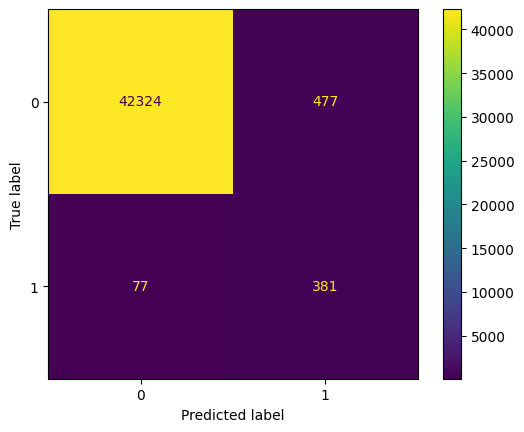

In [107]:
previsoes = modelo_dnn.predict(X_teste_preprocessado)
previsoes_binarias = (previsoes > 0.5).astype(int)

matriz = confusion_matrix(y_teste, previsoes_binarias)
disp = ConfusionMatrixDisplay(confusion_matrix=matriz)
disp.plot()